2025-04-01 23:32:04.085497: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-01 23:32:04.116147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743521524.153180  206114 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743521524.164390  206114 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743521524.192021  206114 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 


Processing U11.SI...


2025-04-01 23:32:10.180676: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/priya/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ppo_policy', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


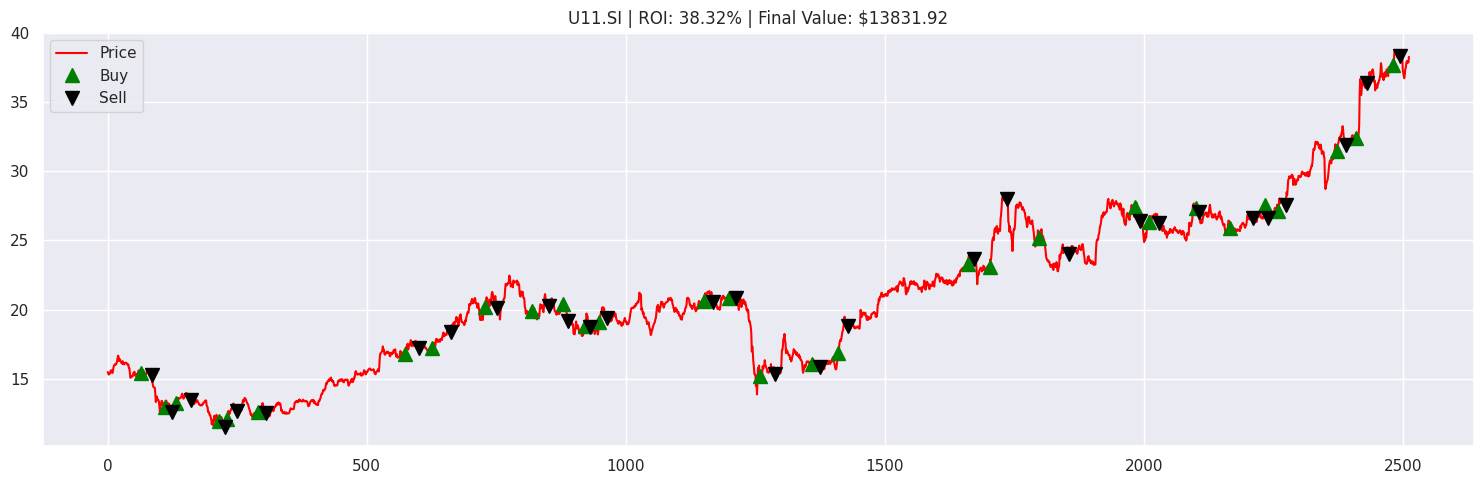


Processing C38U.SI...


/home/priya/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ppo_policy_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


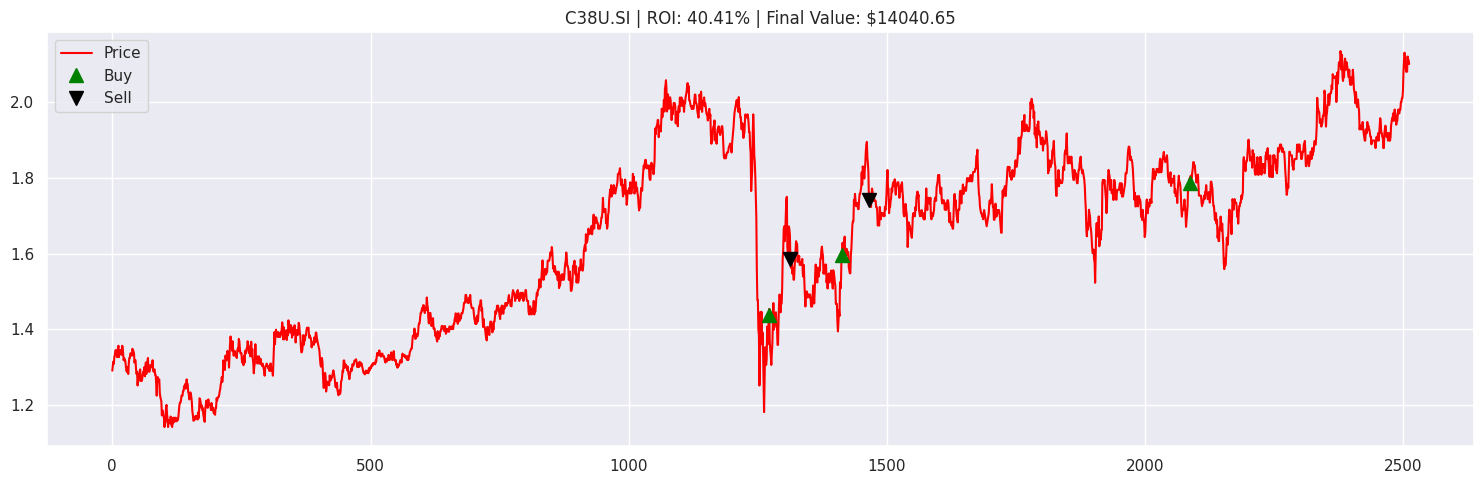


Processing Q0F.SI...


/home/priya/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ppo_policy_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


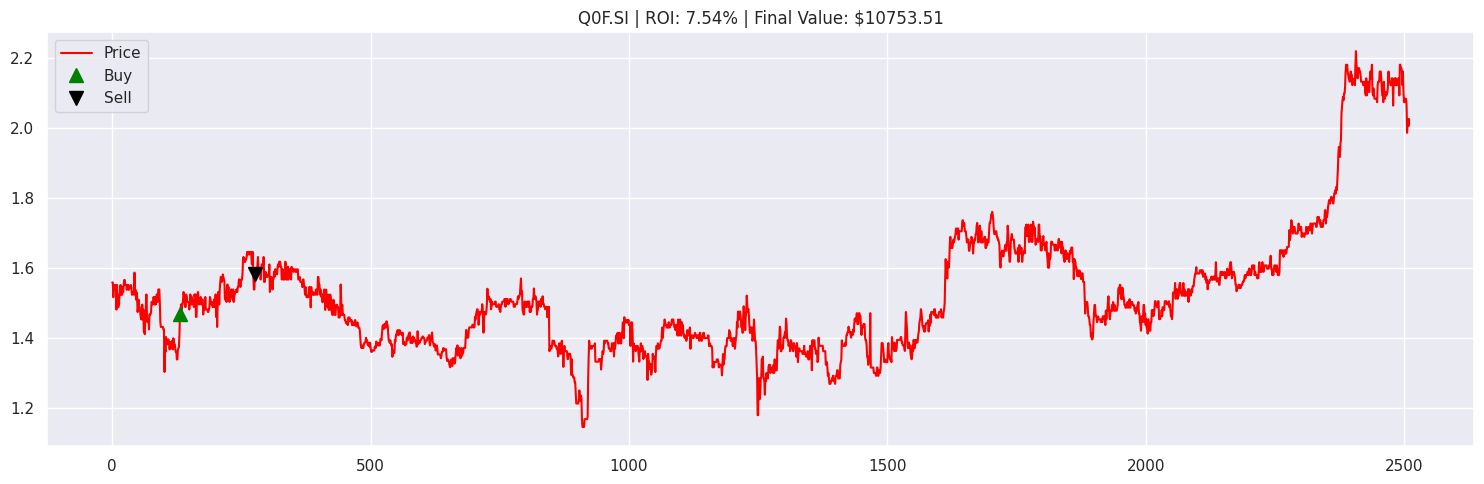


Processing S68.SI...


/home/priya/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ppo_policy_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


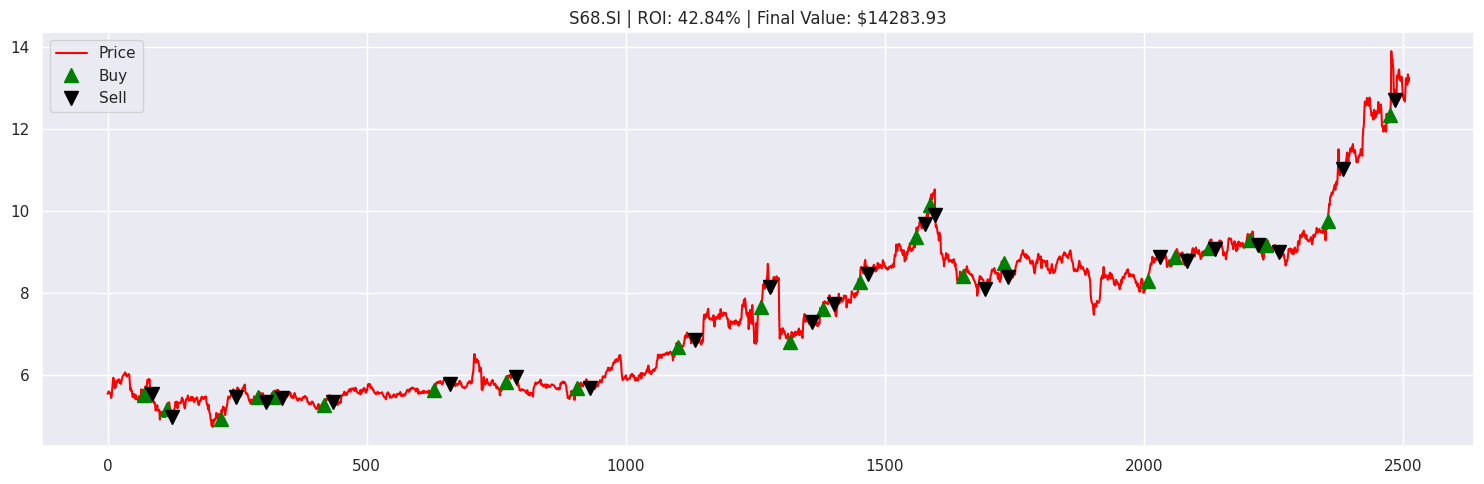


Processing S63.SI...


/home/priya/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ppo_policy_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


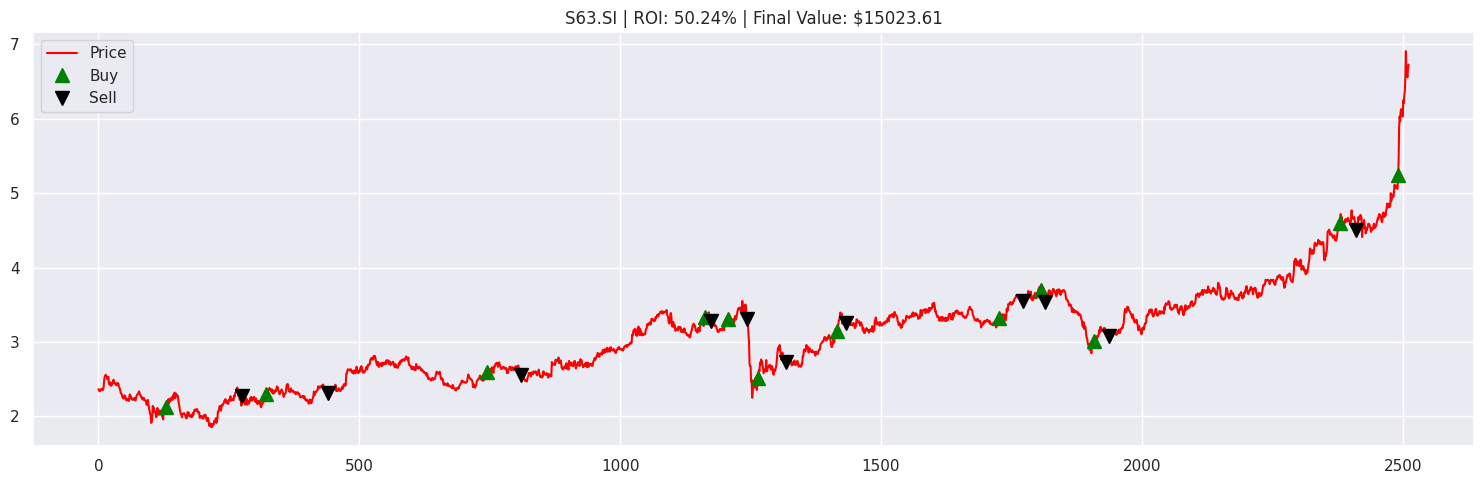


Processing AJBU.SI...


/home/priya/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ppo_policy_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


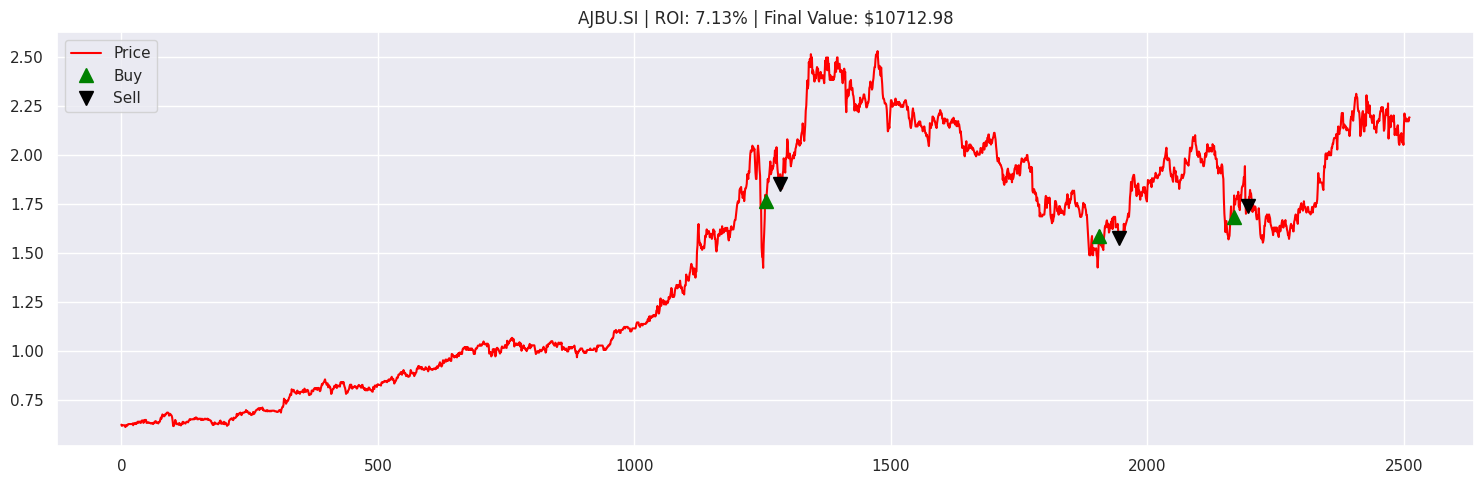


Portfolio Summary:
               ROI   Final Value
U11.SI   38.319249  13831.924948
C38U.SI  40.406460  14040.646040
Q0F.SI    7.535134  10753.513428
S68.SI   42.839350  14283.934982
S63.SI   50.236069  15023.606928
AJBU.SI   7.129813  10712.981315


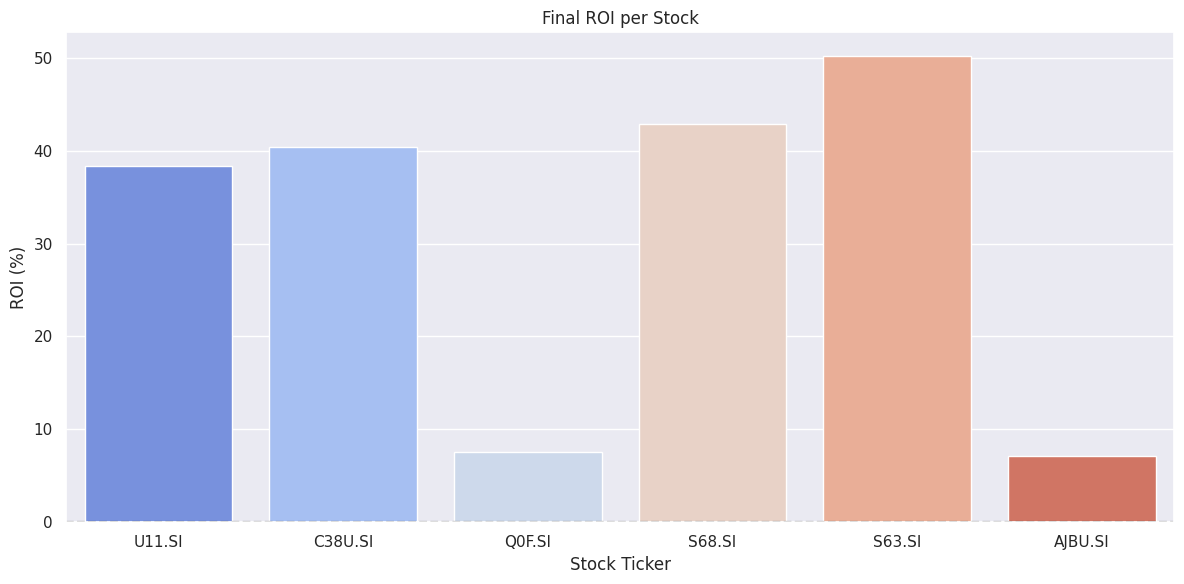

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import random

sns.set()

# Parameters
initial_money = 10000
window_size = 30
commission = 0.00125
alpha_threshold = 0.01
beta_threshold = -0.01
risk_rsi_low = 30
risk_rsi_high = 70
min_trade_profit = 0.005

# Indicator Functions
def RMA(series, period):
    rma = [series[0]]
    alpha = 1 / period
    for price in series[1:]:
        rma.append((1 - alpha) * rma[-1] + alpha * price)
    return np.array(rma)

def apply_second_order_rma(prices):
    return RMA(RMA(prices, 25), 9)

def compute_macd(prices, short=12, long=26, signal=9):
    ema_short = pd.Series(prices).ewm(span=short).mean()
    ema_long = pd.Series(prices).ewm(span=long).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=signal).mean()
    return macd_line.values, signal_line.values

def compute_rsi(prices, period=14):
    delta = np.diff(prices)
    up = np.where(delta > 0, delta, 0)
    down = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(up).rolling(window=period).mean()
    avg_loss = pd.Series(down).rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return np.concatenate([np.full(period, np.nan), rsi[period:]])

# PPO Agent
class PPOPolicy(tf.keras.Model):
    def __init__(self, input_dim, output_dim):
        super(PPOPolicy, self).__init__()
        self.lstm = tf.keras.layers.LSTM(128, return_sequences=True, return_state=True)
        self.actor = tf.keras.layers.Dense(output_dim, activation='softmax')
        self.critic = tf.keras.layers.Dense(1)

    def call(self, inputs, states):
        x, h, c = self.lstm(inputs, initial_state=states)
        logits = self.actor(x[:, -1])
        value = self.critic(x[:, -1])
        return logits, value, (h, c)

class PPOAgent:
    def __init__(self, input_dim, action_dim):
        self.policy = PPOPolicy(input_dim, action_dim)
        self.policy.build(input_shape=(None, None, input_dim))
        self.optimizer = tf.keras.optimizers.Adam(0.0003)
        self.gamma = 0.99
        self.clip_ratio = 0.2
        self.state_dim = input_dim
        self.action_dim = action_dim

    def get_state(self, t, trend):
        d = t - window_size + 1
        block = trend[d:t+1] if d >= 0 else -d * [trend[0]] + trend[0:t+1]
        delta = [block[i+1] - block[i] for i in range(window_size - 1)]
        rma2 = apply_second_order_rma(block)[-1]
        macd_line, signal_line = compute_macd(block)
        rsi = compute_rsi(block)
        macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
        rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50
        return np.array(delta + [rma2, macd_diff, rsi_val])

    def get_action(self, state):
        state = state.reshape(1, 1, -1).astype(np.float32)
        hidden = [tf.zeros((1, 128)), tf.zeros((1, 128))]
        probs, _, _ = self.policy(state, hidden)
        action = np.random.choice(self.action_dim, p=probs.numpy()[0])
        return action

# Execution Loop
portfolio_results = {}
tickers = {
    "U11.SI": "UOB Bank",
    "C38U.SI": "CapitaLand Integrated Commercial Trust",
    "Q0F.SI": "IHH Healthcare",
    "S68.SI": "SGX",
    "S63.SI": "ST Engineering",
    "AJBU.SI": "Keppel DC REIT"
}

for ticker in tickers:
    print(f"\nProcessing {ticker}...")
    df = pd.read_csv(f"/home/priya/Desktop/fyp/Agents/data_store/{ticker}.csv")
    df = df.dropna(subset=["Close"])  # Drop any NaNs in Close
    close = df['Close'].values.tolist()
    if len(close) < window_size + 20:
        print(f"Skipping {ticker} due to insufficient data.")
        continue

    agent = PPOAgent(window_size - 1 + 3, 3)
    portfolio = initial_money
    shares_held = 0
    states_buy, states_sell = [], []

    for t in range(window_size, len(close) - 1):
        state = agent.get_state(t, close)
        action = agent.get_action(state)

        macd_line, signal_line = compute_macd(close[max(0, t-50):t+1])
        macd_diff = macd_line[-1] - signal_line[-1] if len(macd_line) else 0
        rsi = compute_rsi(close[max(0, t-50):t+1])
        rsi_val = rsi[-1] if not np.isnan(rsi[-1]) else 50

        current_price = close[t]
        expected_profit = close[t+1] * (1 - commission) - current_price * (1 + commission)

        trade_action = 0
        if action == 1 and macd_diff > alpha_threshold and rsi_val < risk_rsi_high and expected_profit > min_trade_profit * current_price:
            trade_action = 1
        elif action == 2 and macd_diff < beta_threshold and rsi_val > risk_rsi_low and shares_held > 0:
            trade_action = 2

        if trade_action == 1 and portfolio >= current_price * (1 + commission):
            shares_to_buy = portfolio // (current_price * (1 + commission))
            portfolio -= shares_to_buy * current_price * (1 + commission)
            shares_held += shares_to_buy
            states_buy.append(t)
        elif trade_action == 2 and shares_held > 0:
            portfolio += shares_held * current_price * (1 - commission)
            shares_held = 0
            states_sell.append(t)

    portfolio_value = portfolio + shares_held * close[-1]
    roi = (portfolio_value - initial_money) / initial_money * 100
    portfolio_results[ticker] = {"ROI": roi, "Final Value": portfolio_value}

    plt.figure(figsize=(15, 5))
    plt.plot(close, label='Price', color='red')
    plt.plot(close, '^', markersize=10, color='green', label='Buy', markevery=states_buy)
    plt.plot(close, 'v', markersize=10, color='black', label='Sell', markevery=states_sell)
    plt.title(f"{ticker} | ROI: {roi:.2f}% | Final Value: ${portfolio_value:.2f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

results_df = pd.DataFrame(portfolio_results).T
print("\nPortfolio Summary:")
print(results_df)
results_df.to_csv('results_ppo.csv')

plt.figure(figsize=(12, 6))
sns.barplot(x=results_df.index, y=results_df["ROI"], hue=results_df.index, dodge=False, palette="coolwarm", legend=False)
plt.axhline(y=0, color='black', linestyle='--')
plt.title("Final ROI per Stock")
plt.ylabel("ROI (%)")
plt.xlabel("Stock Ticker")
plt.tight_layout()
plt.show()
